# Setup

In [4]:
with open('../data/names.txt') as nfile:
    words = nfile.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
from string import ascii_lowercase

BOUNDARY = "."

alphabet = [BOUNDARY] + list(ascii_lowercase)

ctoi = {c: i for i, c in enumerate(alphabet)}

ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

# Build Sample Training Set

In [34]:
import torch

# context length: how many previous characters are considered when predicting the next
# n is used since, in bengio et al. 2003, this relates to ngram size
n = 3

# training set
X, Y = [], []

for word in words[:3]:
    print(word)
    context = [0] * n # when n = 3, results in [0, 0, 0]
    for c in word + BOUNDARY:
        i = ctoi[c]
        X.append(context) # add context
        Y.append(i) # add result

        print("".join(alphabet[j] for j in context), "->", c)

        # update context (crop & append)
        context = context[1:] + [i]

X = torch.tensor(X).short()
Y = torch.tensor(Y).short()

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .


In [35]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int16, torch.Size([16]), torch.int16)

In [36]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]], dtype=torch.int16)

In [37]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0],
       dtype=torch.int16)

# Embeddings

In [Bengio et al.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), embeddings are referred to as the feature vectors. The feature vectors "embed" the word/character into an `m`-dimensional space, where `m` is the number of features. The feature vectors are learned from the training set, alowing for words/characters to cluster together according to similarities relevant to the loss function. Because embedding features are learned, the network is free to use each feature in any way it sees fit.

In [38]:
features = 2 # in bengio et al. 2003, this is 30
C = torch.randn(len(alphabet), features)

In [39]:
C.shape

torch.Size([27, 2])

In [40]:
# naive lookup
C[5]

tensor([0.2566, 2.4348])

In [44]:
import torch.nn.functional as F

# vectorized lookup - similar to applying bit mask
xenc = F.one_hot(torch.tensor(5), num_classes=len(alphabet)).short()
xenc.float() @ C

tensor([0.2566, 2.4348])

In [46]:
# possible to index using list or tensor
C[torch.tensor([5, 6, 7, 7])]

tensor([[0.2566, 2.4348],
        [0.0904, 0.7293],
        [1.0082, 0.4794],
        [1.0082, 0.4794]])

In [51]:
C.shape, X.shape, C[X.long()].shape

(torch.Size([27, 2]), torch.Size([16, 3]), torch.Size([16, 3, 2]))

`C[X]` adds embeddings to the input data. The embeddings are learned during training. The embeddings are added to the input data as additional columns. The number of columns added is the number of embeddings specified. The embeddings are initialized to random values. 

In [53]:
# context for each character in input
emb = C[X.long()]

# Hidden Layer

In [55]:
# each neuron will accept features for each character in context
layer_inputs = n * features

# layer size (total neurons) is arbitrary
layer_size = 100

W1 = torch.randn(layer_inputs, layer_size)
b1 = torch.randn(layer_size)

In [56]:
emb.shape, W1.shape

(torch.Size([16, 3, 2]), torch.Size([6, 100]))

Ultimately, we want to do something like `emb @ W1 + b1`. However, the matrix shapes are not compatible. 

In [58]:
emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape,

(torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2]))

Above, we see one method to extract the embeddings for each input. To pass to the hidden layer, we need to flatten the embeddings. We can do this by concatenating the embeddings for each input into a single vector for each input.

Using `torch.view` to interpret the 1st and 2nd dimensions as a single dimension, we flatten the embeddings for each input into a single vector.

In [66]:
emb.view(-1, layer_inputs).shape

torch.Size([16, 6])

In [69]:
h = emb.view(-1, layer_inputs) @ W1 + b1

h.shape

torch.Size([16, 100])

# Loss Function

In [70]:
W2 = torch.randn(layer_size, len(alphabet))
b2 = torch.randn(len(alphabet))

In [72]:
logits = h @ W2 + b2

logits.shape

torch.Size([16, 27])

In [75]:
counts = logits.exp()

prob = counts / counts.sum(dim=1, keepdim=True)

prob.shape

torch.Size([16, 27])

In [76]:
prob[0].sum()

tensor(1.0000)

In [77]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0],
       dtype=torch.int16)

In [80]:
# peek predictions for each label in the training set (after training, should approach 1)
prob[torch.arange(16), Y.long()]

tensor([2.1321e-10, 2.9531e-24, 1.6483e-21, 1.5406e-28, 1.2106e-24, 1.3649e-01,
        1.8415e-26, 6.8954e-26, 1.0000e+00, 1.4099e-25, 2.2900e-28, 1.1657e-24,
        1.9179e-18, 1.3328e-14, 1.4013e-45, 2.8128e-08])

In [86]:
loss = -prob[torch.arange(16), Y.long()].log().mean()
loss

tensor(45.7488)

# Summary

In [87]:
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

In [88]:
n = 3
features = 2

print(f"{n=} | {features=}")

n=3 | features=2


In [120]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(alphabet), features, generator=g)
W1 = torch.randn(n * features, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, len(alphabet), generator=g)
b2 = torch.randn(len(alphabet), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [91]:
total_params = sum(p.nelement() for p in parameters)

print(f"{total_params=}")

total_params=3481


In [102]:
emb = C[X.long()]
h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(16), Y.long()].log().mean()
loss

tensor(20.2417)

In [105]:
F.cross_entropy(logits, Y.long())

tensor(20.2417)

Since `cross_entropy` is equivalent to softmax + negative log likelihood, we will use `cross_entropy` going forward.

In [112]:
for _ in range(1000):
    # forward pass
    emb = C[X.long()]
    h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y.long())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

loss

tensor(0.2078, grad_fn=<NllLossBackward0>)

# Full Training Set

In [115]:
X, Y = [], []

for word in words:
    context = [0] * n # when n = 3, results in [0, 0, 0]
    for c in word + BOUNDARY:
        i = ctoi[c]
        X.append(context) # add context
        Y.append(i) # add result

        # update context (crop & append)
        context = context[1:] + [i]

X = torch.tensor(X).short()
Y = torch.tensor(Y).short()

In [116]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int16, torch.Size([228146]), torch.int16)

In [118]:
minibatch_size = 32

torch.randint(0, X.shape[0], (minibatch_size, ))

tensor([172865, 114526,  56012, 110553, 171862, 164318,  21101,   9256,  85273,
         34367, 188306,  44975,  53569, 147967,  25913,  10629, 115341, 222165,
        164544,  66092,  81100, 151601,  87474, 167385,  66276, 141372, 196245,
        204040, 222291, 118785,  60008, 225419])

In [129]:
# 3m 46s w/o minibatching
# 1.3s w/ minibatching

for _ in range(1000):
    # micro-batching
    ix = torch.randint(0, X.shape[0], (minibatch_size, ))
    uX = X.long()[ix]
    uY = Y.long()[ix]

    # forward pass
    emb = C[uX]
    h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, uY)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

loss

tensor(2.6106, grad_fn=<NllLossBackward0>)

In [130]:
emb = C[X.long()]
h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y.long())

loss

tensor(2.5414, grad_fn=<NllLossBackward0>)

# Determining Learning Rate

In [132]:
lr_exp = torch.linspace(-3, 0, 1000)

lrs = 10 ** lr_exp

lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [141]:
# re-initialize parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(alphabet), features, generator=g)
W1 = torch.randn(n * features, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, len(alphabet), generator=g)
b2 = torch.randn(len(alphabet), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# stats
iterations = 1000
lr_exp_recorded = [0] * iterations
loss_recorded = [0] * iterations

# learn with increasing learning rates each iteration
for i in range(iterations):
    # micro-batching
    ix = torch.randint(0, X.shape[0], (minibatch_size, ))
    uX = X.long()[ix]
    uY = Y.long()[ix]

    # forward pass
    emb = C[uX]
    h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, uY)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update w/ different learning rates
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    # record stats
    lr_exp_recorded[i] = lr_exp[i]
    loss_recorded[i] = loss.item()

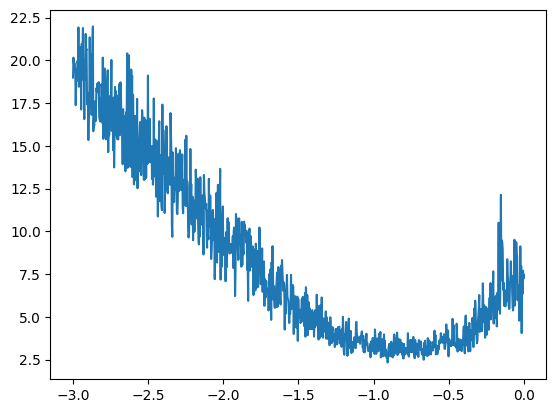

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lr_exp_recorded, loss_recorded)

When learning rate is too low, the gradient descent is slow to converge. When learning rate is too high, the gradient descent overshoots the minimum, causing the loss function to oscillate and loss to increase.

The plot above shows that a good learning rate is around `10**-1`.

In [146]:
# re-initialize parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(alphabet), features, generator=g)
W1 = torch.randn(n * features, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, len(alphabet), generator=g)
b2 = torch.randn(len(alphabet), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# gradient descent config
phases = 3 # weight decay after each phase
iterations = 40000
initial_lr = 10**-1

def lr_with_decay(i):
    phase = i // iterations
    return initial_lr * (0.1 ** phase)

# learn with weight decay
for i in range(phases * iterations):
    # micro-batching
    ix = torch.randint(0, X.shape[0], (minibatch_size, ))
    uX = X.long()[ix]
    uY = Y.long()[ix]

    # forward pass
    emb = C[uX]
    h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, uY)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update w/ weigh decay
    lr = lr_with_decay(i)
    for p in parameters:
        p.data -= lr * p.grad

In [147]:
emb = C[X.long()]
h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y.long())

loss

tensor(2.3021, grad_fn=<NllLossBackward0>)

# Training Sets: Train, Dev, Test

Training: 80%, used to train parameters

Dev: 10%, used to test hyperparameters

Test: 10%, used to evaluate model performance

In [151]:
import random
from typing import Collection, Tuple
def build_dataset(words: "Collection[str]", n: "int" = 3) -> "Tuple[torch.Tensor, torch.Tensor]":
    X, Y = [], []
    for word in words:
        context = [0] * n
        for c in word + BOUNDARY:
            i = ctoi[c]
            X.append(context)
            Y.append(i)

            # update context (crop & append)
            context = context[1:] + [i]

    X = torch.tensor(X).short()
    Y = torch.tensor(Y).short()
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)

ix_dev = int(len(words) * 0.8)
ix_test = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:ix_dev])
Xdev, Ydev = build_dataset(words[ix_dev:ix_test])
Xtest, Ytest = build_dataset(words[ix_test:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


# Hyperparameter Tuning

Finding the best hyperparameters is a process of trial and error. The best hyperparameters are the ones that minimize the loss function on the dev set. In this model, the hyperparameters are the number of neurons in the hidden layer and the size of the embeddings vector.

First, we try increasing the hidden layer size from `100` to `300`.

In [159]:
# re-initialize parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(alphabet), features, generator=g)
h_size = 300
W1 = torch.randn(n * features, h_size, generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn(h_size, len(alphabet), generator=g)
b2 = torch.randn(len(alphabet), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# gradient descent config
phases = 3 # weight decay after each phase
iterations = h_size * 400 # more parameters = more iterations
initial_lr = 10**-1

def lr_with_decay(i):
    phase = i // iterations
    return initial_lr * (0.1 ** phase)

# learn with weight decay
for i in range(phases * iterations):
    # micro-batching
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size, ))
    uX = Xtr.long()[ix]
    uY = Ytr.long()[ix]

    # forward pass
    emb = C[uX]
    h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, uY)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update w/ weigh decay
    lr = lr_with_decay(i)
    for p in parameters:
        p.data -= lr * p.grad

In [160]:
emb = C[Xdev.long()]
h = torch.tanh(emb.view(-1, n * features) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev.long())

loss

tensor(2.2115, grad_fn=<NllLossBackward0>)

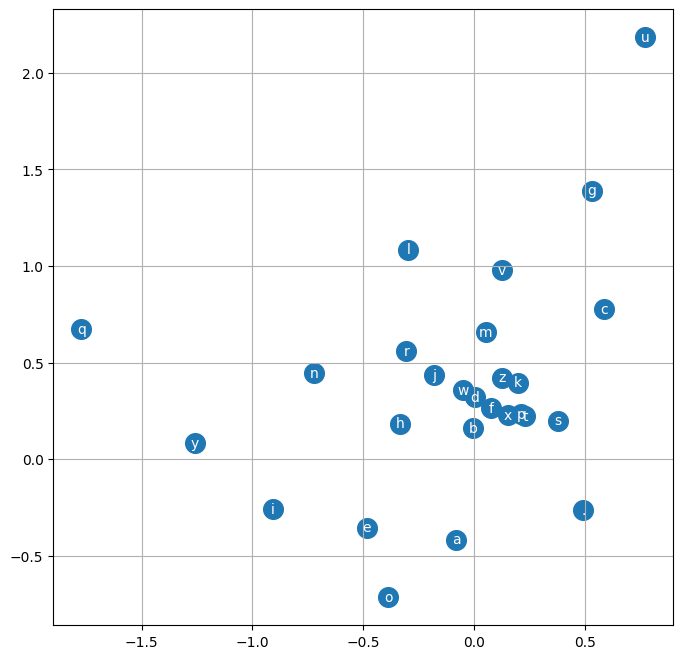

In [162]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), alphabet[i], ha="center", va="center", color="white")
plt.grid("minor")

Next, we reduce the hidden layer size from `300` to `200`, and increase the embedding vector size from `2` to `10`.

In [163]:
# re-initialize parameters
emb_size = 10
h_size = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(alphabet), emb_size, generator=g)
W1 = torch.randn(n * emb_size, h_size, generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn(h_size, len(alphabet), generator=g)
b2 = torch.randn(len(alphabet), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# gradient descent config
phases = 4 # weight decay after each phase
iterations = h_size * emb_size * 200 # more parameters = more iterations
initial_lr = 10**-1

def lr_with_decay(i):
    phase = i // iterations
    return initial_lr * (0.1 ** phase)

# learn with weight decay
for i in range(phases * iterations):
    # micro-batching
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size, ))
    uX = Xtr.long()[ix]
    uY = Ytr.long()[ix]

    # forward pass
    emb = C[uX]
    h = torch.tanh(emb.view(-1, n * emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, uY)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update w/ weigh decay
    lr = lr_with_decay(i)
    for p in parameters:
        p.data -= lr * p.grad

In [165]:
emb = C[Xdev.long()]
h = torch.tanh(emb.view(-1, n * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev.long())

loss

tensor(2.1137, grad_fn=<NllLossBackward0>)

# Evaluation

In [166]:
emb = C[Xtest.long()]
h = torch.tanh(emb.view(-1, n * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest.long())

loss

tensor(2.1211, grad_fn=<NllLossBackward0>)

In [177]:
from typing import Collection

g = torch.Generator().manual_seed(2147483647)

def predict_successor(context: "Collection[int]") -> "int":
    """
    input:
        context: a list of integers representing indices of previous characters in the alphabet

    returns: index of the next character in the alphabet
    """
    emb = C[context]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    return ix

def predict_name():
    context = [0] * n
    ix = predict_successor(context)

    name = []
    while alphabet[ix] != ".":
        name += alphabet[ix]
        context = context[1:] + [ix]
        ix = predict_successor(context)

    return "".join(name)

for _ in range(20):
    print(predict_name())

cexzen
jalynn
ilah
tyta
kalima
taine
kayla
andrastaryaulyansh
got
shiv
jenan
kinzie
darek
emiless
suhakaviyah
folst
huciden
tahlan
kashru
antil
